In [70]:
import nltk as nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as stop
import pandas as pd
import numpy as np
import math
import re
import spacy
from spacy.cli.download import download
download(model="en_core_web_sm")
import string

from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pyLDAvis.gensim_models
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls


import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soumy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\soumy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Reading Data

In [71]:
#df = pd.read_csv('Gamestop_Oct20_Dec20.csv')
#df = pd.read_csv('Gamestop_Jan21_Mar21.csv')
df = pd.read_csv('Gamestop_Apr21_Oct21.csv')
df[:5]

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,snscrape.modules.twitter.Tweet,https://twitter.com/Jana51164382/status/132232...,2020-10-30 23:58:41+00:00,@Wanheda21281411 okay the market is getting in...,@Wanheda21281411 okay the market is getting in...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",6,0,0,...,NaN,NaN,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN
1,snscrape.modules.twitter.Tweet,https://twitter.com/MR_TOO_SOON/status/1322326...,2020-10-30 23:57:26+00:00,@RoyalBoyle78 @PadresFan_OS @Bluengold34 I’m s...,@RoyalBoyle78 @PadresFan_OS @Bluengold34 I’m s...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,NaN,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN
2,snscrape.modules.twitter.Tweet,https://twitter.com/Howbtdemcowboys/status/132...,2020-10-30 23:55:45+00:00,@Im_Just_Drayson I want the headset I already ...,@Im_Just_Drayson I want the headset I already ...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,NaN,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN
3,snscrape.modules.twitter.Tweet,https://twitter.com/RoyalBoyle78/status/132232...,2020-10-30 23:55:33+00:00,@MR_TOO_SOON @PadresFan_OS @Bluengold34 my ser...,@MR_TOO_SOON @PadresFan_OS @Bluengold34 my ser...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,NaN,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN
4,snscrape.modules.twitter.Tweet,https://twitter.com/tiffanyoxide/status/132232...,2020-10-30 23:55:26+00:00,My nephew called the GameStop by where I live ...,My nephew called the GameStop by where I live ...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",3,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
def clean_tweet(tweet):
    temp = tweet.lower()
    temp = re.sub(r"@[A-Za-z0-9_]+","", temp)
    temp = re.sub(r"#[A-Za-z0-9_]+","", temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    ###############Removing emojis###############
    emoj = re.compile("[" u"\U0001F600-\U0001F64F"  # emoticons
               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
               u"\U0001F680-\U0001F6FF"  # transport & map symbols
               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
               u"\U00002702-\U000027B0"
               u"\U000024C2-\U0001F251"
               u"\U0001f926-\U0001f937"
               u"\u200d"
               u"\u2640-\u2642" 
               "]+", flags=re.UNICODE)
    temp = re.sub(emoj, '', temp)
    temp = temp.split()
    return temp

###########################################################################
#Taking all the words and making a list
cleanup = []

for word in df['content']:
    cleanup.append(word)

#Cleaned up version of words in the list
cleaned_words = []
c = 0
while c < len(cleanup):
    cleaned_words.append(clean_tweet(cleanup[c]))
    c += 1
    
#Making a sentence out of cleaned words and putting clean sentence in a column
cleaned_sentence = []
d = 0
while d < len(cleaned_words):
    cleaned_sentence.append(' '.join(cleaned_words[d]))
    cleaned_sentence[d] = re.sub(r'@[A-Za-z0-9_]+|#[A-Za-z0-9_]+|http\S+|^\s+|\s+$', '', cleaned_sentence[d])
    d += 1
    
df['cleaned_sentence'] = cleaned_sentence

#Check word counts
all_words = []
i = 0
j = 0

while i < len(cleaned_sentence):
    j = 0
    while j < len(cleaned_sentence[i].split()):
        all_words.append(cleaned_sentence[i].split()[j])
        j += 1
    i += 1
    
    
# Mapping words to the corresponding tweet in the dataframe
def to_word(x):
    return x.split()

df['words'] = df['cleaned_sentence'].map(to_word)
df.head()

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,cleaned_sentence,words
0,snscrape.modules.twitter.Tweet,https://twitter.com/Jana51164382/status/132232...,2020-10-30 23:58:41+00:00,@Wanheda21281411 okay the market is getting in...,@Wanheda21281411 okay the market is getting in...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",6,0,0,...,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,okay the market is getting in a position for b...,"[okay, the, market, is, getting, in, a, positi..."
1,snscrape.modules.twitter.Tweet,https://twitter.com/MR_TOO_SOON/status/1322326...,2020-10-30 23:57:26+00:00,@RoyalBoyle78 @PadresFan_OS @Bluengold34 I’m s...,@RoyalBoyle78 @PadresFan_OS @Bluengold34 I’m s...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,i’m sorry bro i hate gamestop so much man it w...,"[i’m, sorry, bro, i, hate, gamestop, so, much,..."
2,snscrape.modules.twitter.Tweet,https://twitter.com/Howbtdemcowboys/status/132...,2020-10-30 23:55:45+00:00,@Im_Just_Drayson I want the headset I already ...,@Im_Just_Drayson I want the headset I already ...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,i want the headset i already reserved the syst...,"[i, want, the, headset, i, already, reserved, ..."
3,snscrape.modules.twitter.Tweet,https://twitter.com/RoyalBoyle78/status/132232...,2020-10-30 23:55:33+00:00,@MR_TOO_SOON @PadresFan_OS @Bluengold34 my ser...,@MR_TOO_SOON @PadresFan_OS @Bluengold34 my ser...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,my series x got canceled by gamestop 3 weeks a...,"[my, series, x, got, canceled, by, gamestop, 3..."
4,snscrape.modules.twitter.Tweet,https://twitter.com/tiffanyoxide/status/132232...,2020-10-30 23:55:26+00:00,My nephew called the GameStop by where I live ...,My nephew called the GameStop by where I live ...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",3,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,my nephew called the gamestop by where i live ...,"[my, nephew, called, the, gamestop, by, where,..."


In [73]:
#This splits all the sentences up which makes it easier for us to work with
all_sentences = []

for word in df.cleaned_sentence:
    all_sentences.append(word)

all_sentences


lines = list()
for line in all_sentences:    
    words = line.split()
    for w in words: 
        lines.append(w)

df.head()

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,cleaned_sentence,words
0,snscrape.modules.twitter.Tweet,https://twitter.com/Jana51164382/status/132232...,2020-10-30 23:58:41+00:00,@Wanheda21281411 okay the market is getting in...,@Wanheda21281411 okay the market is getting in...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",6,0,0,...,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,okay the market is getting in a position for b...,"[okay, the, market, is, getting, in, a, positi..."
1,snscrape.modules.twitter.Tweet,https://twitter.com/MR_TOO_SOON/status/1322326...,2020-10-30 23:57:26+00:00,@RoyalBoyle78 @PadresFan_OS @Bluengold34 I’m s...,@RoyalBoyle78 @PadresFan_OS @Bluengold34 I’m s...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,i’m sorry bro i hate gamestop so much man it w...,"[i’m, sorry, bro, i, hate, gamestop, so, much,..."
2,snscrape.modules.twitter.Tweet,https://twitter.com/Howbtdemcowboys/status/132...,2020-10-30 23:55:45+00:00,@Im_Just_Drayson I want the headset I already ...,@Im_Just_Drayson I want the headset I already ...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,i want the headset i already reserved the syst...,"[i, want, the, headset, i, already, reserved, ..."
3,snscrape.modules.twitter.Tweet,https://twitter.com/RoyalBoyle78/status/132232...,2020-10-30 23:55:33+00:00,@MR_TOO_SOON @PadresFan_OS @Bluengold34 my ser...,@MR_TOO_SOON @PadresFan_OS @Bluengold34 my ser...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,my series x got canceled by gamestop 3 weeks a...,"[my, series, x, got, canceled, by, gamestop, 3..."
4,snscrape.modules.twitter.Tweet,https://twitter.com/tiffanyoxide/status/132232...,2020-10-30 23:55:26+00:00,My nephew called the GameStop by where I live ...,My nephew called the GameStop by where I live ...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",3,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,my nephew called the gamestop by where i live ...,"[my, nephew, called, the, gamestop, by, where,..."


In [74]:
#Removing Punctuation
lines = [re.sub(r'[^A-Za-z0-9]+', '', x) for x in lines]
lines2 = []

for word in lines:
    if word != '':
        lines2.append(word)

#Lemmatization
lemmatizer = WordNetLemmatizer()
lemma = []
for word in lines2:
    lemma.append(lemmatizer.lemmatize(word))

#Removing stopwords from lemmatized words  (list of words)
stop_words=set(stop.words("english"))
lemma2 = []
for word in lemma:
    if word not in stop_words:
        lemma2.append(word)
        
df.head()

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,cleaned_sentence,words
0,snscrape.modules.twitter.Tweet,https://twitter.com/Jana51164382/status/132232...,2020-10-30 23:58:41+00:00,@Wanheda21281411 okay the market is getting in...,@Wanheda21281411 okay the market is getting in...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",6,0,0,...,NaN,NaN,NaN,"[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,okay the market is getting in a position for b...,"[okay, the, market, is, getting, in, a, positi..."
1,snscrape.modules.twitter.Tweet,https://twitter.com/MR_TOO_SOON/status/1322326...,2020-10-30 23:57:26+00:00,@RoyalBoyle78 @PadresFan_OS @Bluengold34 I’m s...,@RoyalBoyle78 @PadresFan_OS @Bluengold34 I’m s...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,i’m sorry bro i hate gamestop so much man it w...,"[i’m, sorry, bro, i, hate, gamestop, so, much,..."
2,snscrape.modules.twitter.Tweet,https://twitter.com/Howbtdemcowboys/status/132...,2020-10-30 23:55:45+00:00,@Im_Just_Drayson I want the headset I already ...,@Im_Just_Drayson I want the headset I already ...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,i want the headset i already reserved the syst...,"[i, want, the, headset, i, already, reserved, ..."
3,snscrape.modules.twitter.Tweet,https://twitter.com/RoyalBoyle78/status/132232...,2020-10-30 23:55:33+00:00,@MR_TOO_SOON @PadresFan_OS @Bluengold34 my ser...,@MR_TOO_SOON @PadresFan_OS @Bluengold34 my ser...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,1,...,NaN,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...","[{'_type': 'snscrape.modules.twitter.User', 'u...",NaN,NaN,NaN,NaN,my series x got canceled by gamestop 3 weeks a...,"[my, series, x, got, canceled, by, gamestop, 3..."
4,snscrape.modules.twitter.Tweet,https://twitter.com/tiffanyoxide/status/132232...,2020-10-30 23:55:26+00:00,My nephew called the GameStop by where I live ...,My nephew called the GameStop by where I live ...,1.320000e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",3,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,my nephew called the gamestop by where i live ...,"[my, nephew, called, the, gamestop, by, where,..."


In [75]:
#Removing Collection words from lemmatized words
collection_words = ['gamestop','gamestops', 'gme', 'game','dont', 'still', 'like', 'wa', 'get', 'got', 'im', 'no', 'go', '2', 
                    'ha', 'said', 'one', 'know', 'lol', 'going', 'u', 'say', 'hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 
                    'im', 'want', 'like', '$', '@', 'mine', 'ps5', 'xbox', 'would', 'thats', 'even', 'back', 'x', 'ps5s', 
                    'de', 'via', 'see', 'edt', 'v2', 'pm', 'went', 'que', 'new', 'en', 'el']
for word in list(lemma2):  # iterating on a copy since removing will mess things up
    if word in collection_words:
        lemma2.remove(word)

#Renaming for making code easier to read        
word_corpus=lemma2

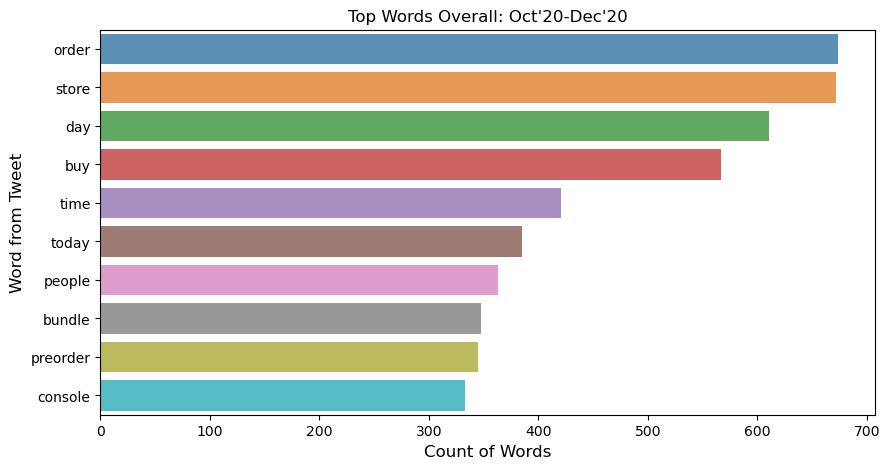

In [76]:
df_words = pd.DataFrame(word_corpus, columns = ['Words'])
df_words_vc = df_words['Words'].value_counts()

df_words_vc_top = df_words_vc[:10,]
plt.figure(figsize=(10,5))
sns.barplot(df_words_vc_top.values, df_words_vc_top.index, alpha=0.8)
plt.title("Top Words Overall: Apr'21-Sep'21")
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()


In [8]:
#Showing entities being spoken in the text
def show_ents(doc):
    if doc.ents:
        for ent in doc.ents:
            print(ent.text + ' - ' + ent.label_ + ' - ' + str(spacy.explain(ent.label_)))

In [9]:
nlp.max_length = 3000000 # or even higher
str1 = " " 
lemma3 = str1.join(lemma2)
word_corpus_sentence = nlp(lemma3) #Words joined by space for the whole cleaned tweets

label = [(X.text, X.label_) for X in word_corpus_sentence.ents]

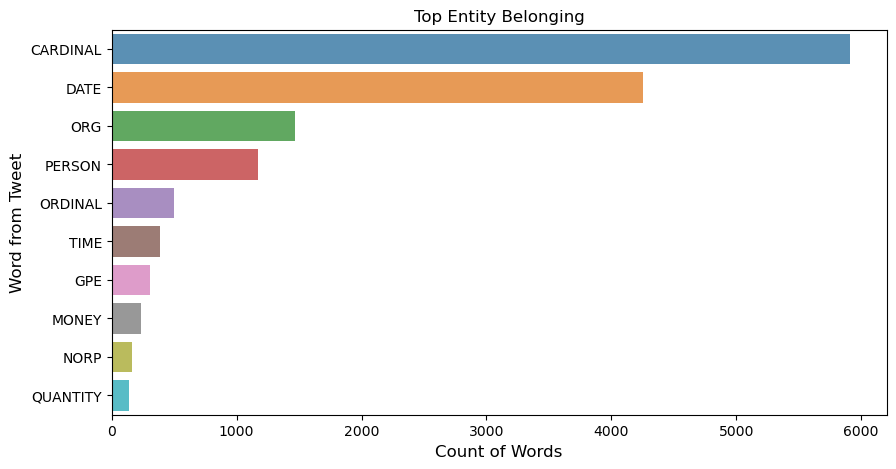

In [10]:
df_entity = pd.DataFrame(label, columns = ['Word','Entity'])
df_entity_vc = df_entity['Entity'].value_counts()

df_entity_vc_top10 = df_entity_vc[:10,]
plt.figure(figsize=(10,5))
sns.barplot(df_entity_vc_top10.values, df_entity_vc_top10.index, alpha=0.8)
plt.title('Top Entity Belonging')
plt.ylabel('Word from Tweet', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

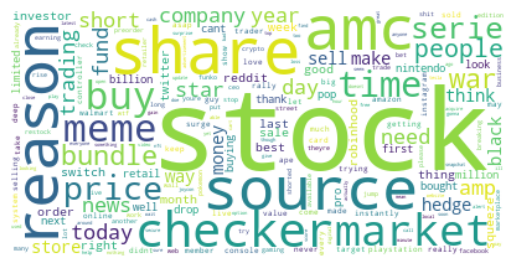

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(str(word_corpus_sentence))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Topic Modeling

In [12]:
# Tokenizer
tokenizer = Tokenizer(nlp.vocab)


# Custom stopwords
custom_stopwords = ['hi','&amp;', ' ', '.', '-', 'got', "i'm", 'im', 'want', 'like','$','dont', 'still', 'like', 'wa', 'get', 
                    'got', 'im', 'no', 'go', '2','ha', 'said', 'one', 'know', 'lol', 'going', 'u', 'say', 'mine', 'ps5', 'xbox', 
                    'would', 'thats', 'even', 'back','gamestop','gamestops', 'gme', 'game','\n','\n\n', '&amp;', ' ', '.', '-', 
                    "it's",'im', 'want', 'like', '$', '@', 'x', 'ps5s','de', 'via', 'see', 'edt', 'v2', 'pm', 'went', 
                    'que', 'new', 'en', 'el']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)


tokens = []

for doc in tokenizer.pipe(df['cleaned_sentence'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens

In [13]:
# Make tokens a string again
df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in df['tokens']]

def get_lemmas(text):
    '''Used to lemmatize the processed tweets'''
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['lemmas'] = df['tokens_back_to_text'].apply(get_lemmas)

In [14]:
# Make lemmas a string again
df['lemmas_back_to_text'] = [' '.join(map(str, l)) for l in df['lemmas']]

# Tokenizer function
def tokenize(text):
    """
    Parses a string into a list of semantic units (words)
    Args:
        text (str): The string that the function will tokenize.
    Returns:
        list: tokens parsed out
    """
    # Removing url's
    pattern = r"http\S+"
    
    tokens = re.sub(pattern, "", text) 
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    tokens = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    tokens = re.sub('@*!*\$*', '', text) # Remove @ ! $
    tokens = tokens.strip(',') 
    tokens = tokens.strip('?') 
    tokens = tokens.strip('!') 
    tokens = tokens.strip("'") 
    tokens = tokens.strip(".") 

    tokens = tokens.lower().split() # Make text lowercase and split it
    
    return tokens

# Apply tokenizer
df['lemma_tokens'] = df['lemmas_back_to_text'].apply(tokenize)

In [15]:
# Create a id2word dictionary
id2word = Dictionary(df['lemma_tokens'])
print(len(id2word))


# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.99)
print(len(id2word))

# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in df['lemma_tokens']]

# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

# Create Topics
topics = [' '.join(t[0:10]) for t in words]

# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

17034
8390
------ Topic 0 ------
stock amc gamestop reason checker source meme price bundle war

------ Topic 1 ------
stock share reason source checker switch nintendo sale instantly asap

------ Topic 2 ------
stock buy gamestop market order gme time good series amc

------ Topic 3 ------
stock market reason fund source checker short hedge amc share

------ Topic 4 ------
stock gme amc meme share gamestop buy short reason source



In [16]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=df['lemma_tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -7.282643804907382

Coherence Score:  0.31522038702354455


In [27]:
df['date'] = df['date'].astype('datetime64[ns]')
df_sept = df.loc[(df['date'] >= '2021-09-01') & (df['date'] < '2021-09-30')]

In [33]:
analyzer= SentimentIntensityAnalyzer()

#Add VADER metrics to dataframe
df_sept['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df_sept['cleaned_sentence']]
df_sept['negative'] = [analyzer.polarity_scores(v)['neg'] for v in df_sept['cleaned_sentence']]
df_sept['neutral'] = [analyzer.polarity_scores(v)['neu'] for v in df_sept['cleaned_sentence']]
df_sept['positive'] = [analyzer.polarity_scores(v)['pos'] for v in df_sept['cleaned_sentence']]
df_sept.head(3)

,_type,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,...,coordinates,place,hashtags,cashtags,cleaned_sentence,words,compound,negative,neutral,positive
321,snscrape.modules.twitter.Tweet,https://twitter.com/ARS2117/status/14433632685...,2021-09-29 23:53:14,@D21Beast Yeah I seen it was in stock at GameS...,@D21Beast Yeah I seen it was in stock at GameS...,1.443360e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",1,0,0,...,NaN,NaN,NaN,NaN,yeah i seen it was in stock at gamestop a coup...,"[yeah, i, seen, it, was, in, stock, at, gamest...",-0.0772,0.052,0.882,0.066
322,snscrape.modules.twitter.Tweet,https://twitter.com/SteamFocus/status/14433625...,2021-09-29 23:50:23,PS5 Restock Update: GameStop Has PS5 Bundles F...,PS5 Restock Update: GameStop Has PS5 Bundles F...,1.443360e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,1,...,NaN,NaN,"['PS4', 'Xbox', 'Streamer']",NaN,ps5 restock update: gamestop has ps5 bundles f...,"[ps5, restock, update:, gamestop, has, ps5, bu...",0.3612,0.000,0.937,0.063
323,snscrape.modules.twitter.Tweet,https://twitter.com/BURNERA56462776/status/144...,2021-09-29 23:14:36,NO WAY!? Acquire Gamestop stock shares on INST...,NO WAY!? Acquire Gamestop stock shares on INST...,1.443350e+18,"{'_type': 'snscrape.modules.twitter.User', 'us...",0,0,0,...,NaN,NaN,NaN,NaN,no way acquire gamestop stock shares on instag...,"[no, way, acquire, gamestop, stock, shares, on...",-0.2263,0.287,0.559,0.154


In [69]:
def sentiment_type(compound):
    if compound > 0:
        return 'Positive'
    elif compound < 0:
        return 'Negative'
    else:
        return 'Neutral'

df_sept['sentiment'] = df_sept['compound'].apply(sentiment_type)
df_sept['date'] = pd.to_datetime(df_sept['date']).dt.date

df_positive = df_sept.loc[df_sept['sentiment'] == 'Positive']

df_summary = pd.DataFrame(df_positive.groupby(['date','sentiment'])['sentiment'].count())
df_summary

,,sentiment
date,sentiment,
2021-09-01,Positive,52
2021-09-02,Positive,49
2021-09-03,Positive,31
2021-09-04,Positive,27
2021-09-05,Positive,23
2021-09-06,Positive,27
2021-09-07,Positive,33
2021-09-08,Positive,90
2021-09-09,Positive,120
